In [1]:
# standard lib:
import glob

# ML/data science libraries:
import numpy as np
import pandas as pd
from annoy import AnnoyIndex

# TenserFlow/Keras classes:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalMaxPool2D

# plotting and imaging:
import cv2
import matplotlib.pyplot as plt

2022-06-02 10:15:51.608987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 10:15:51.609059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Get Files:

In [2]:
# n.b. we don't need to sort since we're not training the model:
def get_file_paths():
    """ Create generator of all image file paths.

    :return {generator}
    """

    # We could also have used `pathlib.Path().glob()`, but that returns a POSIX path rather than str:
    return glob.iglob('../data/e-commerce-product-images/**/*.jpg', recursive=True)

file_paths = get_file_paths()

## Explore Data -- i.e. images:
N.b. the dataset includes different size images and images with different number of channels (i.e. both RGB and grayscale) images.

AxesImage(54,36;334.8x217.44)


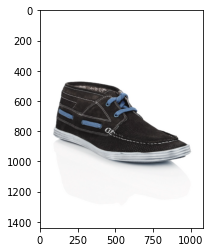

In [3]:
example_img = cv2.imread(next(file_paths))
print(plt.imshow(example_img))

# reset generator:
file_paths = get_file_paths()

## Load ResNet Model:

In [4]:
# constants:
IMG_HEIGHT  = 224
IMG_WIDTH   = 224

resnet_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
resnet_model.trainable = False

resnet_model.summary()

2022-06-02 10:15:58.483952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 10:15:58.484043: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 10:15:58.484082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ogedei): /proc/driver/nvidia/version does not exist
2022-06-02 10:15:58.484551: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [5]:
# Update the model by adding a global max pooling layer:
# In essence, we replaced the last couple layers of the original ResNet model with a layer that outputs the embedding/features of the image.
# Recall that global pooling always reduces the output to be shape 1 x 1 x channels; essentially, outputting a layer of feature-maps.
model = Sequential([
    resnet_model,
    GlobalMaxPool2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


**Aside:** if we didn't specify `include_top=False` in `resnet_model` from the previous two cells,
we could alternatively have created a new model and get the last 3rd to last layer:
```
resnet_model_ = ResNet50V2(weights='imagenet')
```

This would, however, result in the exact same model:
```
feature_extraction_model = Model(
    name='ResNet50V2_ExtractFeature',
    inputs=resnet_model_.inputs,
    outputs=resnet_model_.get_layer('post_relu').output
)
```

In [6]:
# Helper methods:

def process_image(img:np.ndarray):
    """ Pre-process images before feeding to model.

    Resizes image, scales (/255), and expands array dimension. The model requires specific input dimensions (shape),
    therefore resizing and adding dimension is necessary. Scaling improves performance.
    TODO: ideally, we should use standard deviation and mean of dataset instead of simply dividing by 255.

    :param img:
    :return {np.ndarray}: returns processed image
    """
    # see comparison of different interpolation methods: <https://chadrick-kwag.net/cv2-resize-interpolation-methods/>
    processed_img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

    # We can use TF's ResNet `preprocess_input` <https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input>
    # however, because the datasets are quite different, it might do more harm than good <https://stackoverflow.com/a/58250681>;
    # we can therefore, simply divide by 255:
    processed_img = processed_img / 255

    # ResNet model expects input shape (batch_size, img_height, img_width, channels) -- we need to add batch_size dimension:
    processed_img = np.expand_dims(processed_img, axis=0)
    return processed_img

def get_embedding(file_path:str):
    img = cv2.imread(file_path)
    img = process_image(img)
    embedding = model.predict(img)
    embedding = np.squeeze(embedding) # ensure output is 1D array

    return embedding

## Build Step: calculate the embedding vectors and k-approximate-nearest-neighbor index

The Amazon Berkeley Objects (ABO) Dataset has more than 147,000 products.
If we want each bucket to have 20 items, then $\frac{147,000}{20}=7,350$ buckets.
Each hyperplane divides the space into 2. So, $2^{n}=7,350 \therefore n = \log_{2}7,350 \approx 13$. Thus, we need 13 hyperplanes per instance.

In [7]:
NUM_HYPERPLANES = 13
# The last layer in model is the embedding vector, so we can grab the shape of that:
VECTOR_DIM = model.get_layer('global_max_pooling2d').output.shape[1] # each embedding is length 2048

In [8]:
%%time

# See Annoy docs: <https://github.com/spotify/annoy>
annoy_ = AnnoyIndex(VECTOR_DIM, 'angular')

df_embeddings = pd.DataFrame(columns=['id', 'file', 'file_path', 'embedding'], dtype=object)

# TODO: can we optimize/speed-up this, perhaps via batch processing?
for i, file_path_ in enumerate(file_paths):
    embedding_ = get_embedding(file_path_)
    file_name_ = file_path_.split('/')[-1]

    annoy_.add_item(i, embedding_)

    # TODO: this should be replaced with SQLite or dict:
    df_embeddings = df_embeddings.append({'id': i, 'file': file_name_, 'file_path': file_path_, 'embedding': embedding_}, ignore_index=True, sort=False)

# Build and save Annoy index:
annoy_.build(NUM_HYPERPLANES)
annoy_.save('../models/local.img_embedding.ann')

CPU times: user 36min 17s, sys: 55.3 s, total: 37min 12s
Wall time: 14min 54s


True

## Find Similar Images:

In [18]:
def find_similar_images(img_path:str, num_results:int=5):
    # N.b. if user searches for an image that already exists in database,
    # we DO want to return the exact same image; it's not a duplicate result.

    # Load single image, process, and get embedding:
    target_embedding = get_embedding(img_path)

    ids_of_matches = annoy_.get_nns_by_vector(target_embedding, num_results)
    top_matches = [{'file_path': df_embeddings.iloc[id]['file_path'], 'file_name': df_embeddings.iloc[id]['file']} for id in ids_of_matches]
    return top_matches

In [25]:
def display_similar_images(img_path:str, num_results:int=5):
    top_results = find_similar_images(img_path, num_results)

    # display multiple images; see <https://stackoverflow.com/q/19471814>:
    for result in top_results: # recall `top_results` returns a tuple of (similarity, file_path)
        img = cv2.imread(result['file_path'])
        plt.figure()
        plt.title(result['file_name'])
        plt.imshow(img)

----- Selected Image: -----


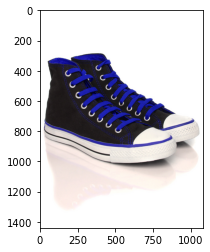

In [26]:
example_img_path = '../data/e-commerce-product-images/Footwear/Men/Images/images_with_product_ids/3797.jpg'

print('----- Selected Image: -----')
plt.imshow(cv2.imread(example_img_path))

----- Similar Images: -----


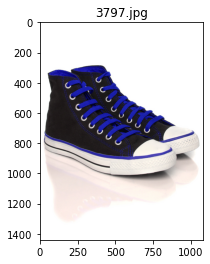

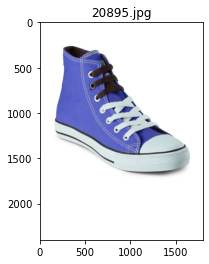

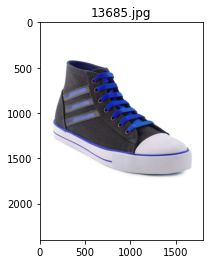

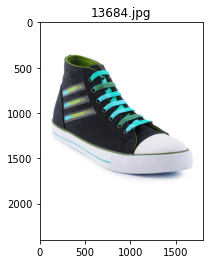

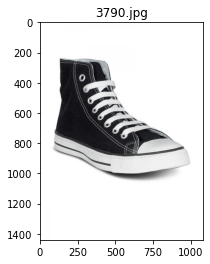

In [27]:
print('----- Similar Images: -----')
display_similar_images(example_img_path)